# Backpropagation

This notebook provides an overview of back propagation.

In [4]:
import numpy as np

# Preliminaries

## Chain Rule

We'll see backpropagation is just chain rule, so let's nail that down before we get into backprop.

Two notations and one picture...

### Functions

If $h(x) = f(g(x))$

then $h^{'} = f^{'}(g(x))g^{'}(x)$

### Using intermediate variables

$z = f(g(x))$

Let $y=g(x)$.

Then $z = f(y)$.

$\frac{dz}{dx} = \frac{dz}{dy} \frac{dy}{dx}$

### In pictures

If moving the left-most rod some small amount moves the middle rod by 2x that amount and moving the middle rod by some small amount moves the right-most rod by 3x that amount, then moving the left-most rod a small amount moves the right one by 6x that amount.

![in pictures](derivative.png)

## Computing a derivative

The definition of a derivative is $f^{'}(x) = lim_{h->0}\frac{f(x+h) - f(x)}{h}$

In a picture, this formula looks like this, as the two points move closer to one another.

![tangent](tangent.png)

There are two ways of computing the gradient: analyically and numerically.

### Numerically

The naive approach to computing the gradient is to take the formula / picture and perform the math at some point on some function.  To do this, you execute the function twice, once at $f(x)$ and again at $f(x+h)$ for a small h.  Since you can't let $h$ go to zero, often we use a point slightly on either side of the point of interest $f^{'}(x) = lim_{h->0}\frac{f(x+h) - f(x-h)}{2h}$.

For example, to compute the derivative of $f(x) = x^2$ at $x=3$, we'd pick a small h (say, 0.000001) and find the slope of the line between the points (3-h, f(3-h)) and (3+h, f(3+h)). 

In [14]:
def numerical_derivative(func, x, h):
    # Finds the derivative of func at x.
    return (func(x + h) - func(x - h)) / (2 * h)

f = lambda x: x * x
numerical_derivative(f, 3, 0.000001)

6.000000000838668

### Analytically

This is way you learned in high school calculus.  Using the above definition, you can compute the gradient of any function.  For example, $f(x) = x^2$, you'd have:

$$
f^{'}(x) = lim_{h->0}\frac{f(x+h) - f(x)}{h}
 = lim_{h->0}\frac{(x+h)^2 - f(x)^2}{h}
 = lim_{h->0}\frac{2xh + h^2}{h}
 = lim_{h->0}2x + h
 = 2x
$$

Evaluating this at $x=3$, you'll see the numerical solution is very close to the analytic one.

**Now you have a rule** for any $x$.

After a few of these, you start to notice some patterns and derive general rules, i.e. if $f(x) = x^n$, then $f^{'}(x) = nx^{n-1}$.

**Now you have a rule for all functions of a particular form!**

# An Example: Linear Regression

In a linear regression model, you have a feature vector $x$ and a weight vector $w$ that, together, produce a real valued output $\hat{y}$.  During training, this prediction is matched against the desired/labeled output, $y$ and squared error is used to quantify the loss, $L = (y - \hat{y})^2$.

![linear regression](linear.png)

In [12]:
# Example 1: Model with a single feature (and therefore a single weight).
w = np.array([4.0])

# In some specific training example, x = 3 and labeled with y = 15.
x = np.array([3.0])
y = 15

# Run the model
y_hat = x.dot(w)
print('y_hat = xw = {}'.format(y_hat))

# Compute the loss.
loss = np.power(y_hat - y, 2)
print('loss = (y_hat - y)^2 = {}'.format(loss))

y_hat = xw = 12.0
loss = (y_hat - y)^2 = 9.0


### How does our network learn from this example? 

Conceptually, the question we ask is this: "if we tweak the weight a bit one way, does the loss get better or worse?  what about the other way?".  We then move the loss in the "downhill" direction.  We call this algorithm gradient descent and has several implications:

* If neither direction makes it better, we should just leave it alone.
* We only have local, first order, information.  Maybe tweaking it makes it worse in some direction, but if you move it quite a bit farther away then there's an operating point that's a lot better?
* What if some weight isn't involved in making many predictions vs. some that are involved in every prediction... should the size of tweak be the same for both, or do you want to be more aggressive when you know you'll only get a few changes to make changes?  (This most often arises in the weights associated with the embeddings of rare words.)

Various optimizer strategies (momentum, adagrad, adam) have been developed to address these implications.  For the remainder of this notebook, we'll stick to the basic gradient descent formulation of the above intuition:

$\theta := \theta - \alpha \frac{dL}{d\theta}$ where $\theta$ is a vector of all the tunable weights in our model and alpha is a scaling parameter that determines how much we tweak parameters before computing a new gradient estimate.

Let's apply this to the single training example pushed through the network above.  In our example the trainable parameters, $\theta$, consists only of a single weight, $w$.  We need to compute $\frac{dL}{dw}$.

$
\frac{dL}{dw}
= \frac{dL}{d\hat{y}} \times \frac{d\hat{y}}{dw}
= (2\hat{y} - 2y) \times x
= (2 \times 12 - 2 \times 15) \times 3
= -18
$

Let's check our analytical work with the numerical approach above.

In [20]:
def compute_loss_with_weight(w):
    x = np.array([3.0])
    y = 15
    y_hat = x.dot(w)
    loss = np.power(y_hat - y, 2)
    return loss

h = 0.0000000001
w = np.array([4.0])
numerical_grad = (compute_loss_with_weight(w + h) - compute_loss_with_weight(w - h)) / (2 * h)
print('Numerical gradient: {}'.format(numerical_grad))

Numerical gradient: -18.000001489326678


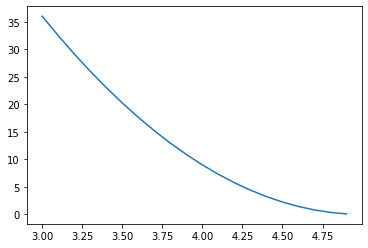

In [36]:
import matplotlib.pyplot as plt
sweep_w = np.arange(3, 5, 0.1)
result = np.array([compute_loss_with_weight(w) for w in sweep_w])
plt.plot(sweep_w, result)

A few notes:

* When optimizing, you're thinking about the loss with respect to the parameters in the network for a given example.  The example is a constant!
* The slope of the loss at some point can change dramatically as you depart from that point. 

### "Backprop"

The fact our gradient was the product of two terms, $\frac{dL}{d\hat{y}}$ and $\frac{d\hat{y}}{dw}$ is the source of the term backprop - each partial product from left to right corresponds with the gradient back from the loss to some point in the network.  This partial product of the gradient back to a particular point in the network is sometimes called the "error signal" to that layer.  In our simple example, it only gets one layer deep.

![linearbp](linearbp.png)

## A more sophisticated example

Let's make our network two layer with a relu in the middle:


$L = (\hat{y} - y)^2$

$\hat{y} = h_1 w_2$

$h_1 = relu(z_1)$

$z_1 = x w_1$

![twolayer](twolayer.png)

In this example, $\theta$ consists of both $w_1$ and $w_2$.  As before, we compute the derivative of the loss with respect to each parameter.  As we'll see, the gradient with respect to $w_1$ with include a lot of the same terms as $w_2$ and $w_2$ itself is exactly the same as above.  This makes sense because from that point in the network onwards, it *is* the same, only with $h_1$ instead of x as the "features".

$\frac{dL}{dw_2}= \frac{dL}{d\hat{y}} \times \frac{d\hat{y}}{dw_2}$

$= (2\hat{y} - 2y) \times h_1$

Computing the gradient with respect to $w_1$ is similar:

$\frac{dL}{dw_1} = \frac{dL}{d\hat{y}} \times \frac{d\hat{y}}{dw_1}$

$= (2\hat{y} - 2y) \times w_2\frac{dh_1}{dw_1}$ (note, $\frac{dw_2}{dw_1}$ = 0)

$= (2\hat{y} - 2y) \times w_2(z_1 > 0)\frac{z_1}{dw_1}$

$= (2\hat{y} - 2y) \times w_2(z_1 > 0)x$

That $(2\hat{y} - 2y)$ is in both calculations shouldn't be a suprise - $\frac{dL}{d\hat{y}}$ is the first step of both!  This is the "error signal" being "backpropagated" to the layer below and is shared by all gradient calculations beyond that point in the network.  Similarly the subsequent $(2\hat{y} - 2y)w_2(z_1 > 0)$ component is shared by any gradient calculations earlier than the second layer of the network.  This slow buildup of shared gradient calculations from the loss back towards the features (and the efficiency of computing these values once and reusing them) gives the calculation a "backwards" flow - the gradient computation propagates back from the loss.

## What if you have multiple weights in a layer?

Up until this point, we only had a single scalar weight in each layer.  If you have a vector of weights (as usual in linear regression) or a matrix of weights (in intermediate layers of deep learning), nothing changes.  You compute the gradient of the loss with respect to each scalar value in those vectors/matrices.  The key question you continue to try to answer is "I'll hold every other weight in this network fixed and tweak just this single one - if I move it slightly higher, does the loss go up or down, and by how much?".

There is a set of [matrix calculus patterns](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) when doing this that can be employed to compute the derivative of the loss with respect to all the scalars in a particular matrix of parameters all at once (as you'd imagine most of the work is duplicative).